In [1]:
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

Explore data

In [2]:
data = pd.read_csv("../data/thailand.csv", index_col=0, parse_dates=True)
data.tail()

,daily_cases
date,
2021-01-09,212
2021-01-10,245
2021-01-11,249
2021-01-12,287
2021-01-13,157


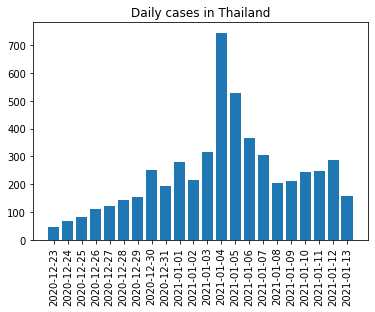

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(data.index, data["daily_cases"])
ax.set_title("Daily cases in Thailand")
ax.set_xticks(data.index)
plt.xticks(rotation=90);

Convert date axis to integers and perform curve fit using scipy

In [4]:
x = data.index.to_julian_date().values
x0 = x[0]
y = data["daily_cases"].values
x-x0, y

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21.]),
 array([ 46,  67,  81, 110, 121, 144, 155, 250, 194, 279, 216, 315, 745,
        527, 365, 305, 205, 212, 245, 249, 287, 157]))

In [5]:
from scipy.optimize import curve_fit
model = lambda t,a,b: a + b*t
popt, pcov = curve_fit(model,  x-x0,  y)
popt

array([129.71541502,  10.48164879])

Check curve fit goodness by visual inspection

In [6]:
data["daily_cases_fit"] = model(x-x0, *popt)
data["total_cases_fit"] = data["daily_cases_fit"].cumsum()

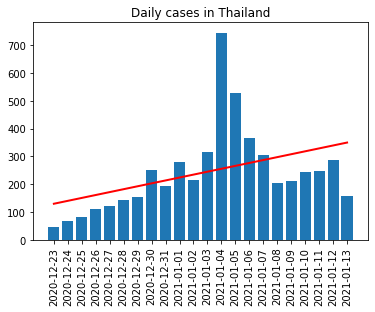

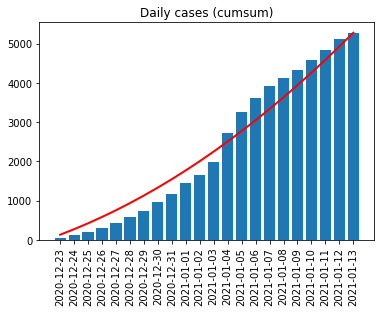

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(data.index, data["daily_cases"])
ax.set_title("Daily cases in Thailand")
ax.set_xticks(data.index)
plt.xticks(rotation=90);
ax.plot(data.index, data["daily_cases_fit"], '-r', lw=2)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(data.index, data["daily_cases"].cumsum())
ax.set_title("Daily cases (cumsum)")
ax.set_xticks(data.index)
plt.xticks(rotation=90);
ax.plot(data.index, data["total_cases_fit"], '-r', lw=2)

LGTM. Let's use curve fit to predict data to the next 10 days.

In [8]:
day_start = data.index[-1] + pd.Timedelta("1 d")
day_end = day_start + pd.Timedelta("10 d")
#day_end = pd.Timestamp("2021-01-13")
new_index = pd.date_range(day_start, day_end)
new_index

DatetimeIndex(['2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-23', '2021-01-24'],
              dtype='datetime64[ns]', freq='D')

In [9]:
prediction = model(new_index.to_julian_date() - x0, *popt)
data2 = pd.DataFrame(prediction, index=new_index, columns=["daily_cases_fit"])
data2["total_cases_fit"] = data["daily_cases"].sum() + data2["daily_cases_fit"].cumsum()
data2

,daily_cases_fit,total_cases_fit
2021-01-14,360.311688,5635.311688
2021-01-15,370.793337,6006.105025
2021-01-16,381.274986,6387.380011
2021-01-17,391.756635,6779.136646
2021-01-18,402.238283,7181.374929
2021-01-19,412.719932,7594.094862
2021-01-20,423.201581,8017.296443
2021-01-21,433.683230,8450.979673
2021-01-22,444.164879,8895.144551
2021-01-23,454.646527,9349.791078


Create visualization combining data, fit and prediction

2021-01-13, f(x) = 129.715 + 10.4816 * t


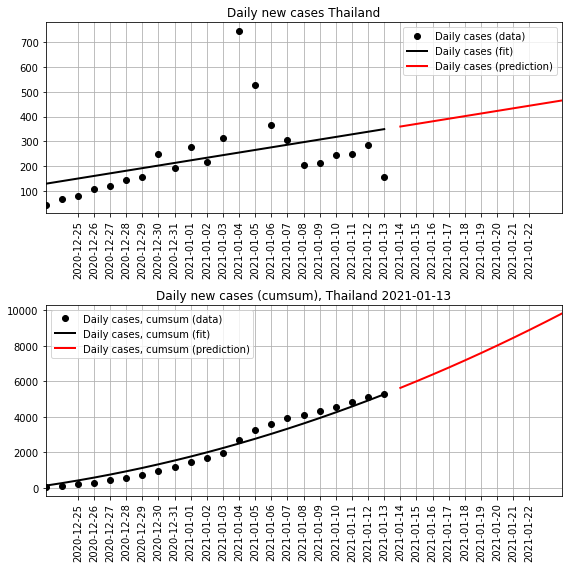

In [10]:
combindex = data.index.union(data2.index)
datestamp = data.index[-1].strftime("%Y-%m-%d")

equation = "%g + %g * t" % (popt[0], popt[1])
eqstr = "%s, f(x) = %s" % (datestamp, equation)
print(eqstr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(data.index, data["daily_cases"], "ko", label="Daily cases (data)")
ax1.set_title("Daily new cases Thailand")
ax1.plot(data.index, data["daily_cases_fit"], '-k', lw=2, label="Daily cases (fit)")
ax1.plot(data2.index, data2["daily_cases_fit"], '-r', lw=2, label="Daily cases (prediction)")
ax1.grid()
ax1.set_xlim(data.index[0], data2.index[-1])
xticks = ax1.get_xticks()
xticks = np.arange(xticks[0], xticks[-1]+2)
ax1.set_xticks(xticks)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.legend()

ax2.plot(data.index, data["daily_cases"].cumsum(), "ko", label="Daily cases, cumsum (data)")
ax2.plot(data.index, data["total_cases_fit"], '-k', lw=2, label="Daily cases, cumsum (fit)")
ax2.plot(data2.index, data2["total_cases_fit"], '-r', lw=2, label="Daily cases, cumsum (prediction)")
ax2.set_title("Daily new cases (cumsum), Thailand %s" % datestamp)
ax2.grid()
ax2.set_xlim(data.index[0], data2.index[-1])
ax2.set_xticks(xticks)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.legend()

fig.tight_layout()
fig.savefig("../figs/%s-prediction.png" % datestamp)
fig.savefig("../figs/%s-prediction.svg" % datestamp)